<a href="https://colab.research.google.com/github/MaayanHagbi/CAS_ADS_Final_Project/blob/main/Fraud_Detection_ML_(CAS_ADS).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Packages

In [1]:
#Google Big Query related packages
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
!pip install geoip2
import geoip2.database
import time

from google.colab import drive
drive.mount('/content/drive')
#Clone Repository
!git clone https://github.com/MaayanHagbi/CAS_ADS_Final_Project

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 2.5 MB/s eta 0:00:00
Mounted at /content/drive
Cloning into 'CAS_ADS_Final_Project'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 39 (delta 11), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (39/39), 132.91 KiB | 7.00 MiB/s, done.
Resolving deltas: 100% (11/11), done.


#Authenticate Google Big Query Access

In [2]:
auth.authenticate_user()
print('Authenticated')

Authenticated


##Connect to Big Query and Get Data

In [63]:
project_id = 'total-biplane-387513'
bigquery_client = bigquery.Client(project = project_id)

Query = "SELECT * FROM `total-biplane-387513.Data_Sceince_Project_Dataset.CAS_ADS_Dataset` limit 10000;"
Query_Results = bigquery_client.query(Query)
df = Query_Results.to_dataframe()
df

#Copy Dataset
Data_Adf = df.copy()

#Account for Null Values
Data_Adf.replace('<NA>', np.nan, inplace=True)

In [4]:
def convert_float(columns):
  for col in columns:
    Data_Adf[col] = pd.to_numeric(Data_Adf[col],errors='coerce')

def convert_string(columns):
  for col in columns:
    Data_Adf[col] = Data_Adf[col].astype(str)

columns_to_string = ['id']
columns_to_float = ['amount_gbp']

convert_float(columns_to_float)
convert_string(columns_to_string)



#Add Is_fraud Column
Data_Adf['Is_fraud'] = Data_Adf['Chargebackreason_id'].notnull()


#Data Analysis

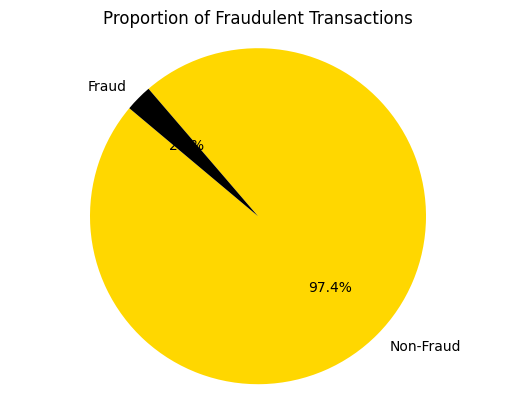

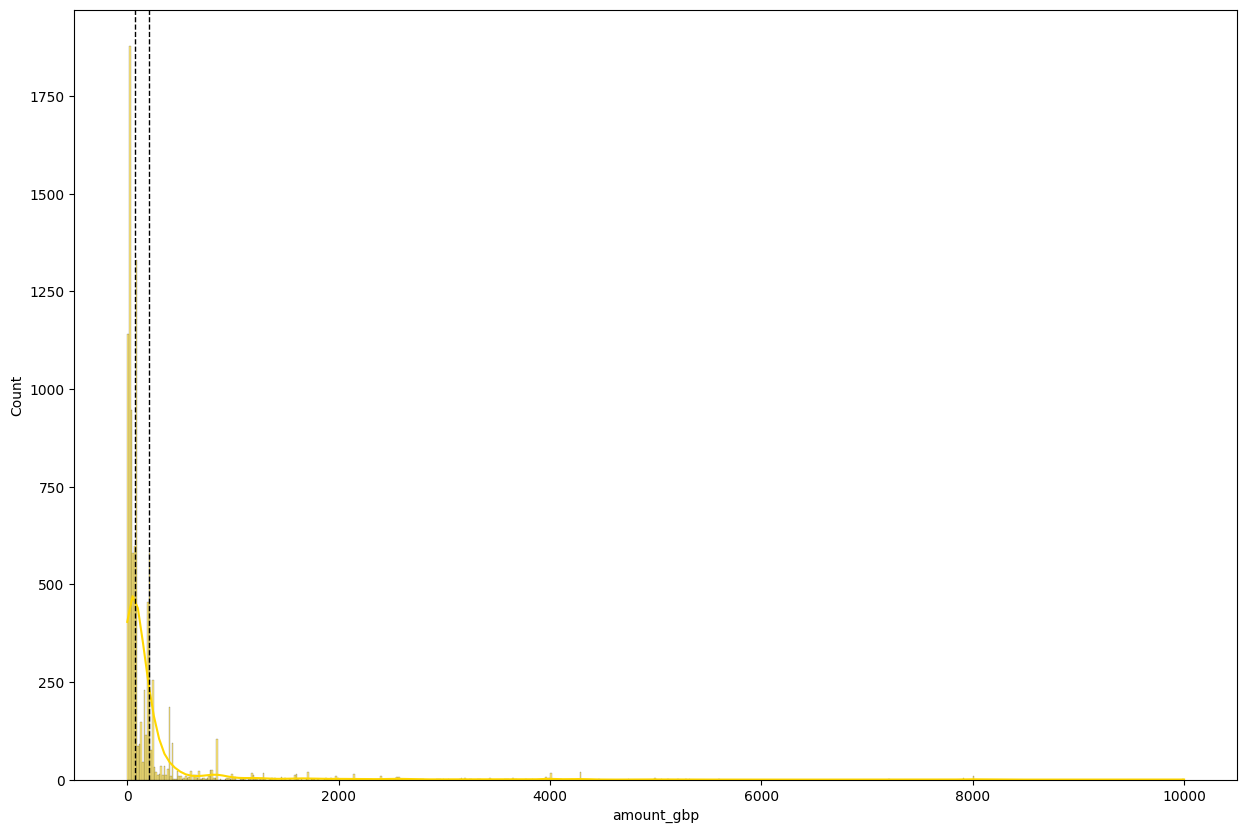

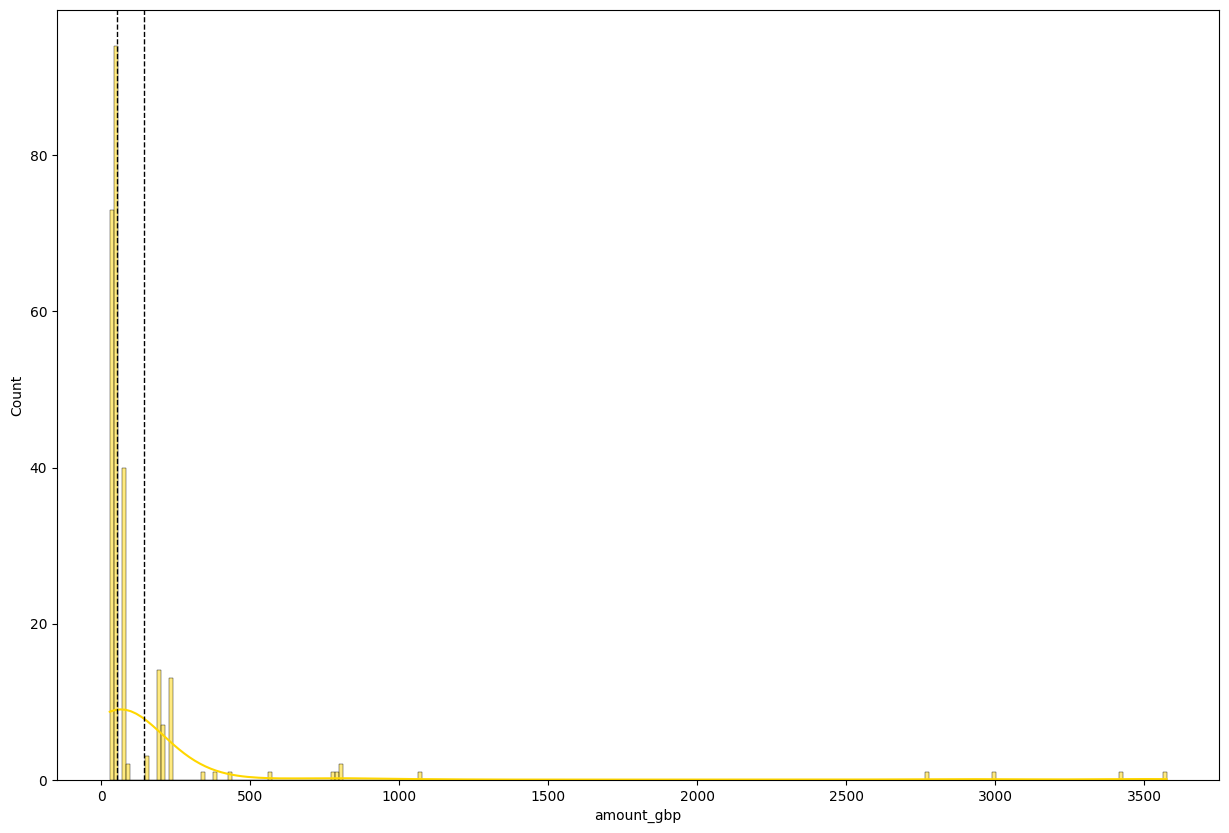

In [5]:
#Look into share of fradulent trx vs non-fraudulent
Data_Adf["Is_fraud"].value_counts().plot.pie(labels=['Non-Fraud','Fraud'],colors=['gold','black'], autopct='%1.1f%%',startangle=140,textprops={'color':"black"})
plt.title('Proportion of Fraudulent Transactions')
plt.ylabel('')
plt.axis('equal')
plt.show()

#Check Amount distribution of Fraudulent Vs non Fraudulent Trx
fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==True]
non_fraudulent_df = Data_Adf[Data_Adf["Is_fraud"]==False]

#Trx_amount_gbp
plt.figure(figsize=(15,10))
sns.histplot(non_fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black')
mean_value = np.mean(non_fraudulent_df["amount_gbp"])
median_value = np.median(non_fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1)
plt.axvline(median_value, color='black', linestyle='dashed', linewidth=1)
plt.show()


plt.figure(figsize=(15,10))
sns.histplot(fraudulent_df["amount_gbp"], kde=True, color='gold', edgecolor='black')
mean_value = np.mean(fraudulent_df["amount_gbp"])
median_value = np.median(fraudulent_df["amount_gbp"])
plt.axvline(mean_value, color='black', linestyle='dashed', linewidth=1)
plt.axvline(median_value, color='black', linestyle='dashed', linewidth=1)
plt.show()

#Generate Customer Profiles

In [10]:
#Calcualte Customer Profile Statistics
cust_profiles = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].agg(['mean','median']).reset_index()
cust_profiles.columns = ['client_id','mean','median']
cust_profiles_std = Data_Adf.groupby('Clientinfo_id')['amount_gbp'].std(ddof=0).reset_index()
cust_profiles_std.columns = ['client_id','std']


#Calcualte Average Number of Trx
Data_Adf['timestamp'] = pd.to_datetime(Data_Adf['timestamp'],errors='coerce')
trx_per_day_per_customer = Data_Adf.groupby(['Clientinfo_id', Data_Adf['timestamp'].dt.date]).size().reset_index(name='num_transactions')
mean_nb_trx_per_day = trx_per_day_per_customer.groupby('Clientinfo_id')['num_transactions'].mean().reset_index()
mean_nb_trx_per_day.columns = ['client_id','mean_nb_trx_per_day']

#Merge Datasets to one
cust_profiles = pd.merge(cust_profiles,cust_profiles_std,on='client_id')
cust_profiles = pd.merge(cust_profiles,mean_nb_trx_per_day,on='client_id')

#Cust_Profiles_Data
cust_profiles

,client_id,mean,median,std,mean_nb_trx_per_day
0,1058659,37.64,37.64,0.0,1.0
1,1058661,157.75,157.75,0.0,1.0
2,1058691,29.98,29.98,0.0,1.0
3,1058711,37.64,37.64,0.0,1.0
4,1059070,53.65,53.65,0.0,1.0
...,...,...,...,...,...
9259,4641619,72.06,72.06,0.0,1.0
9260,4641854,70.46,70.46,0.0,1.0
9261,4642232,31.23,31.23,0.0,1.0
9262,4642409,72.06,72.06,0.0,1.0


## Get Customer Country from IP Address / Card Info

In [57]:
def get_country(ip):
    mmdb_file_path = '/content/drive/MyDrive/CAS_Final_Project/GeoLite2-City.mmdb'

    if pd.notna(ip) and ip != 'nan':
        try:
            with geoip2.database.Reader(mmdb_file_path) as reader:
                response = reader.city(ip)

                country_name = response.country.name
                country_iso_code = response.country.iso_code
                return country_name, country_iso_code
        except Exception as e:
            return None
    else:
        return None

df_Country_lan_lat = pd.read_csv("/content/drive/MyDrive/CAS_Final_Project/Country_lan_lat.csv",sep=';')



#Get Customer Device IP Coordinates (Country)
Cust_Country_Profile_Ip = Data_Adf[['id','Clientinfo_id','Deviceinfo_ip']].copy()
Cust_Country_Profile_Ip['Deviceinfo_ip'] = Cust_Country_Profile_Ip['Deviceinfo_ip'].astype(str)
Cust_Country_Profile_Ip[['country_name','country']] = Cust_Country_Profile_Ip['Deviceinfo_ip'].apply(lambda x:  pd.Series(get_country(x)))

merge_df = pd.merge(Cust_Country_Profile_Ip,df_Country_lan_lat,on='country',how='left')

columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Cust_Country_Profile_Ip = merge_df[columns_to_keep]
print(Cust_Country_Profile_Ip)
old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_ip','longitude_ip']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile_Ip = Cust_Country_Profile_Ip.rename(columns=new_columns_dic)
Cust_Country_Profile_Ip

#Get Customer Card Issuer Bank Coordinates (Country)
Card_Info_Country_Profile = Data_Adf[['id','Clientinfo_id','Countries_iso2']].copy()
old_colums_names = ['Countries_iso2']
new_columns_names = ['country']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)
merge_df = pd.merge(Card_Info_Country_Profile,df_Country_lan_lat,on='country',how='left')
columns_to_keep = ['id','Clientinfo_id','latitude','longitude']
Card_Info_Country_Profile = merge_df[columns_to_keep]
old_colums_names = ['id','Clientinfo_id','latitude','longitude']
new_columns_names = ['id','client_id','latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Card_Info_Country_Profile = Card_Info_Country_Profile.rename(columns=new_columns_dic)
Card_Info_Country_Profile


#Customer Country Coordinates (Final)
merge_df = pd.merge(Cust_Country_Profile_Ip,Card_Info_Country_Profile,on='id')
merge_df.columns
columns_to_keep = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip','latitude_card', 'longitude_card']
Cust_Country_Profile = merge_df[columns_to_keep]
Cust_Country_Profile.columns


old_colums_names = ['id', 'client_id_x', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_names = ['id', 'client_id', 'latitude_ip', 'longitude_ip', 'latitude_card','longitude_card']
new_columns_dic =  {k: v for k, v in zip(old_colums_names,new_columns_names)}
Cust_Country_Profile = Cust_Country_Profile.rename(columns=new_columns_dic)
Cust_Country_Profile

            id  Clientinfo_id   latitude  longitude
0     11540695        4624487  41.377491  64.585262
1     11423943        4577904  38.963745  35.243322
2     11512393        4613370  56.879635  24.603189
3     11328516        4537049  48.019573  66.923684
4     11516446        4614893  41.377491  64.585262
...        ...            ...        ...        ...
9995   2664303        1414490 -22.957640  18.490410
9996   2401898        1286966 -22.957640  18.490410
9997   2173251        1188589 -22.957640  18.490410
9998   2574604        1370615 -22.957640  18.490410
9999   2799983        1466988 -22.957640  18.490410

[10000 rows x 4 columns]


,id,client_id,latitude_ip,longitude_ip,latitude_card,longitude_card
0,11540695,4624487,41.377491,64.585262,41.377491,64.585262
1,11423943,4577904,38.963745,35.243322,38.963745,35.243322
2,11512393,4613370,56.879635,24.603189,38.963745,35.243322
3,11328516,4537049,48.019573,66.923684,38.963745,35.243322
4,11516446,4614893,41.377491,64.585262,41.377491,64.585262
...,...,...,...,...,...,...
9995,2664303,1414490,-22.957640,18.490410,-22.957640,18.490410
9996,2401898,1286966,-22.957640,18.490410,-22.957640,18.490410
9997,2173251,1188589,-22.957640,18.490410,-22.957640,18.490410
9998,2574604,1370615,-22.957640,18.490410,-22.957640,18.490410


## Get Transaction Profile and Customer Behaviour Profile

In [66]:
def time_to_seconds(t):
    return t.hour * 3600 + t.minute * 60 + t.second

def is_weekend(date):
    return date.weekday() >= 5

def get_client_spending_behaviour_features(customer_trx, window_size_in_days = [1,7,30]):

  customer_trx = customer_trx.sort_values('timestamp')
  customer_trx.index = customer_trx.timestamp

  for window_size in window_size_in_days:
    sum_amount_trx_window = customer_trx['amount_gbp'].rolling(str(window_size)+'d').sum()
    nb_trx_window = customer_trx['amount_gbp'].rolling(str(window_size) + 'd').count()

    avg_amount_trx_window = sum_amount_trx_window/nb_trx_window

    print(nb_trx_window)

    customer_trx['customer_id_nb_trx_' + str(window_size) + 'day_window'] = list(nb_trx_window)
    customer_trx['customer_id_avg_amount_'+str(window_size) + 'day_window'] = list(avg_amount_trx_window)

  customer_trx.index = customer_trx.id

  return customer_trx

#Trx Profiles table
Trx_Profile = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()
Trx_Profile.loc[:,'time'] = Trx_Profile['timestamp'].dt.time
Trx_Profile.loc[:,'trx_time_seconds'] = Trx_Profile['time'].apply(lambda x: time_to_seconds(x))
Trx_Profile.loc[:,'date'] = Trx_Profile['timestamp'].dt.date
Trx_Profile.loc[:,'is_WKE?'] = Trx_Profile['date'].apply(lambda x: is_weekend(x)).astype(int)

target_time = pd.to_datetime('22:00:00').time()
Trx_Profile.loc[:,'is_night?'] = (Trx_Profile['time'] > target_time).astype(int)



columns_to_drop = ['time','date']
Trx_Profile = Trx_Profile.drop(columns=columns_to_drop)
old_colums_names = Trx_Profile.columns
new_columns_names = ['id','trx_datetime','client_id','trx_amount_gbp','trx_time_seconds','trx_is_weekend']
new_columns_dic = {k: v for k, v in zip(old_colums_names,new_columns_names)}

Trx_Profile = Trx_Profile.rename(columns=new_columns_dic)


#Customer Behaviour Profile
Trx_Profile_Rolling = Data_Adf[['id','timestamp','Clientinfo_id','amount_gbp']].copy()

Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].dt.tz_localize(None)
Trx_Profile_Rolling['timestamp'] = Trx_Profile_Rolling['timestamp'].astype('datetime64[ns]')

Trx_Profile_Rolling = Trx_Profile_Rolling.sort_values(['timestamp','Clientinfo_id'], ascending=[True,True],ignore_index=True)

client_id_list = Trx_Profile_Rolling['Clientinfo_id'].unique()
client_id_list.dropna()

spending_behaviour_df = pd.DataFrame()

%time Trx_Profile_Rolling = Trx_Profile_Rolling.groupby('Clientinfo_id').apply(lambda x: get_client_spending_behaviour_features(x))

Streaming output truncated to the last 5000 lines.
timestamp
2024-03-05 09:25:17    1.0
Name: amount_gbp, dtype: float64
timestamp
2024-03-05 09:25:17    1.0
Name: amount_gbp, dtype: float64
timestamp
2024-03-05 09:25:17    1.0
Name: amount_gbp, dtype: float64
timestamp
2024-03-05 11:12:08    1.0
Name: amount_gbp, dtype: float64
timestamp
2024-03-05 11:12:08    1.0
Name: amount_gbp, dtype: float64
timestamp
2024-03-05 11:12:08    1.0
Name: amount_gbp, dtype: float64
timestamp
2024-03-05 15:02:11    1.0
Name: amount_gbp, dtype: float64
timestamp
2024-03-05 15:02:11    1.0
Name: amount_gbp, dtype: float64
timestamp
2024-03-05 15:02:11    1.0
Name: amount_gbp, dtype: float64
timestamp
2024-03-08 07:34:33    1.0
Name: amount_gbp, dtype: float64
timestamp
2024-03-08 07:34:33    1.0
Name: amount_gbp, dtype: float64
timestamp
2024-03-08 07:34:33    1.0
Name: amount_gbp, dtype: float64
timestamp
2024-03-05 15:31:03    1.0
Name: amount_gbp, dtype: float64
timestamp
2024-03-05 15:31:03    1.0
Na